# Adults and Foragers Aging Based on Hourly Temperatures Estimate

In [2]:
# make global imports
import copy
from enum import Flag, Enum, auto
import math
import os
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.cbook as cbook

# Column names matching data from the VarroaPop output 
column_names = ["Date", "Colony Size", "Adult Drones", "Adult Workers", "Foragers", "Active Foragers",
                "Capped Drone Brood", "Capped Worker Brood",
                "Drone Larvae", "Worker Larvae", "Drone Eggs", "Worker Eggs", "Total Eggs", "DD", "L", "N", "P", "dd",
                "l", "n", "Free Mites", "Drone Brood Mites",
                "Worker Brood Mites", "Mites/Drone Cell", "Mites/Worker Cell", "Mites Dying", "Proportion Mites Dying",
                "Colony Pollen (g)", "Pollen Pesticide Concentration", "Colony Nectar",
                "Nectar Pesticide Concentration",
                "Dead Drone Larvae", "Dead Worker Larvae", "Dead Drone Adults", "Dead Worker Adults", "Dead Foragers",
                "Queen Strength", "Average Temperature (celsius)", "Rain", "Min Temp", "Max Temp", "Daylight hours",
                "Forage Inc", "Forage Day"]

# Columns to be printed on the X axis of graphs when needed
bees = {
    'columns':['Colony Size', 'Adult Workers', 'Adult Drones', 'Foragers'],
    'palette':['steelblue', 'darkorange', 'green', 'red']
}
bees_extended = {
    'columns':['Colony Size', 'Adult Workers', 'Adult Drones', 'Foragers', 'Capped Drone Brood', 'Drone Larvae', 'Capped Worker Brood', 'Worker Larvae'],
    'palette':['steelblue', 'darkorange', 'green', 'red', 'limegreen', 'palegreen', 'moccasin', 'oldlace']
}
bees_active_inactive_foragers = {
    'columns':['Colony Size', 'Adult Workers', 'Adult Drones', 'Foragers', 'Inactive Foragers'],
    'palette':['steelblue', 'darkorange', 'green', 'red', 'salmon']
}

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%y')

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

# Replace the Date column dates by timeseries panda compatible dates
def enhance_data(output):
    # drop the line number column
    output = output.drop(output.index[0])
    # build a datetime column to be able to restraint to a specific time period
    output["Date"] = pd.to_datetime(output["Date"], format='%m/%d/%Y')
    return output

# Read data from file and process it to be ready for exploitation
def load_data(simulation_output):
    data = pd.read_table(simulation_output, delim_whitespace=True, header=None, names=column_names, skiprows=6)
    data = enhance_data(data)
    return data

def add_monthly_ticks(plot):
    global years, years_fmt, months
    plot.xaxis.set_major_formatter(years_fmt)
    plot.xaxis.set_minor_locator(months)
    

class BeesPlots:
    current_data = None
    updated_data = None
    current_plot = None
    updated_plot = None
    plot = None
    plots = None
    figure = None
    secondary_primary_data = None
    
    class Select(Flag):
        CURRENT = auto()
        UPDATED = auto()
        BOTH = CURRENT | UPDATED
        
    class Type(Flag):
        SINGLE = auto()
        LEFT = auto()
        TOP = auto()
        
    class Secondary(Enum):
        TEMPERATURES = auto(),
        FORAGE_INC = auto(),
        FORAGE_DAY = auto(),
        EGGS = auto()
    
    def __init__(self, p_type = Type.SINGLE):
        if (p_type & self.Type.SINGLE):
            self.figure, self.plot = plt.subplots(nrows=1, ncols=1, figsize=(15, 7.5))
        elif (p_type & self.Type.LEFT):
            self.figure, self.plots = plt.subplots(nrows=1, ncols=2, figsize=(30, 7.5))
        else:
            self.figure, self.plots = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
        self.twin_count = {}
        self.lines = {}
        self.labels = {}
        self.additional_lines = {}
        self.additional_labels = {}
        
    def __make_plots(self, current_title, current, updated_title, updated, columns):
        self.current_data = current
        self.updated_data = updated
        self.current_plot = self.current_data.plot(x='Date', y=columns['columns'], color=columns['palette'], legend=False, ax=self.plots[0])
        self.updated_plot = self.updated_data.plot(x='Date', y=columns['columns'], color=columns['palette'], legend=False, ax=self.plots[1])
        self.twin_count[self.current_plot] = 0
        self.twin_count[self.updated_plot] = 0
        self.additional_lines[self.current_plot] = []
        self.additional_lines[self.updated_plot] = []
        self.additional_labels[self.current_plot] = []
        self.additional_labels[self.updated_plot] = []
        self.lines[self.current_plot], self.labels[self.current_plot] = self.current_plot.get_legend_handles_labels()
        self.lines[self.updated_plot], self.labels[self.updated_plot] = self.updated_plot.get_legend_handles_labels()
        
    def __make_plot(self, title, current, columns):
        self.current_data = current
        self.current_plot = self.current_data.plot(x='Date', y=columns['columns'], color=columns['palette'], legend=False, ax=self.plot)
        self.twin_count[self.current_plot] = 0
        self.additional_lines[self.current_plot] = []
        self.additional_labels[self.current_plot] = []
        self.lines[self.current_plot], self.labels[self.current_plot] = self.current_plot.get_legend_handles_labels()
        
    def add_primary_data(self, data, columns):        
        self.secondary_primary_data = data
        self.secondary_primary_data.plot(x='Date', y=columns['columns'], color=columns['palette'], legend=False, linestyle='--', ax=self.current_plot)        
                        
    def limit(self, start_date, end_date):
        if self.current_plot:
            self.current_plot.set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
        if self.updated_plot:
            self.updated_plot.set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
                
    def limit_left(self, start, end):
        if self.plot:
            pass
        #    self.plot.right_axis.set_xlim(start, end)
        elif len(self.plots)==2:
            self.plots[0].secondary_yaxis.set_xlim(start, end)
            self.plots[1].right_axis.set_xlim(start, end)
        
    def limit_y(self, bottom, top):
        if self.current_plot:
            self.current_plot.set_ylim(bottom, top)
        if self.updated_plot:
            self.updated_plot.set_ylim(bottom, top)
        
    def limit_and_relim(self, start_date, end_date):
        if self.current_plot:
            self.current_plot.set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
            self.current_plot.relim()
        if self.updated_plot:
            self.updated_plot.set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
            self.updated_plot.relim()
        
    def beautifuling(self):
        add_grid(self.plots[0])
        
    def __get_spacing(self, in_plot):
        spacing = .1
        return 1.0 + spacing * self.twin_count[in_plot]
        
    def __get_axis(self, in_plot):
        axis = in_plot.twinx()
        axis.spines['right'].set_position(('axes', self.__get_spacing(in_plot)))
        self.twin_count[in_plot]+=1
        return axis
    
    def __add_legend_data(self, in_plot, axis):
        # Proper legend position
        line, label = axis.get_legend_handles_labels()
        self.additional_lines[in_plot] += line
        self.additional_labels[in_plot] += label
        
    def add_secondary_data(self, kind, which):
        secondary_plot_selector = {
            self.Secondary.TEMPERATURES: self.__add_temperatures,
            self.Secondary.FORAGE_INC: self.__add_forage_inc,
            self.Secondary.FORAGE_DAY: self.__add_forage_day,
            self.Secondary.EGGS: self.__add_eggs
        }
        if kind in secondary_plot_selector.keys():
            self.__call_on_plot(secondary_plot_selector[kind], which)
        else:
            raise Exception("Unsupported kind: " + kind)
        
    def __call_on_plot(self, func, which):
        if (self.current_plot and (which & self.Select.CURRENT)):
            func(self.current_data, self.current_plot)
        if (self.updated_plot and (which & self.Select.UPDATED)):
            func(self.updated_data, self.updated_plot)
        
    def __add_temperatures(self, in_data, in_plot):
        axis = self.__get_axis(in_plot)
        min_temp = in_data.plot(x='Date', y='Min Temp', color='lightgrey', legend=False, ax=axis)
        max_temp = in_data.plot(x='Date', y='Max Temp', color='darkgrey', legend=False, ax=axis)
        # Use weighted averages to reduce noise of min and max temperature data
        # output['Min Temp'] = output['Min Temp'].ewm(span=7, adjust=True).mean()
        # output['Max Temp'] = output['Max Temp'].ewm(span=7, adjust=True).mean()
        max_temp.axhline(12, color="lightgrey", linestyle="--")
        max_temp.axhline(43.3, color="lightgrey", linestyle="--")
        # Name axis
        axis.set_ylabel('Temperatures')
        self.__add_legend_data(in_plot, axis)
            
    def __add_rainfall(self, in_data, in_plot):
        axis = self.__get_axis(in_plot)
        rain = in_data.plot(x='Date', y='Rain', color='darkblue', legend=False, ax=axis)
        # Rain threshold 0.197 * 25.4 to mm
        rain.axhline(0.197*25.4, color="lightgrey", linestyle="--")
        # Name axis
        axis.set_ylabel('Rainfall')
        self.__add_legend_data(in_plot, axis)
            
    def __add_forage_day(self, in_data, in_plot):
        axis = self.__get_axis(in_plot)
        in_data.plot(x='Date', y='Forage Day', color='lightgray', legend=False, ax=axis)
        # Name axis
        axis.set_ylabel('Forage Day')
        self.__add_legend_data(in_plot, axis)
            
    def __add_forage_inc(self, in_data, in_plot):
        axis = self.__get_axis(in_plot)
        forage_inc_plot = in_data.plot(x='Date', y='Forage Inc', color='darkgray', legend=False, ax=axis)
        # Name axis
        axis.set_ylabel('Forage Inc')
        # forage_inc_plot.set_ylim(0.0, 0.01)
        self.__add_legend_data(in_plot, axis)
            
    def __add_eggs(self, in_data, in_plot):
        axis = self.__get_axis(in_plot)
        eggs_plot = in_data.plot(x='Date', y='Total Eggs', color='purple', legend=False, ax=axis)
        self.__add_legend_data(in_plot, axis)
        if self.secondary_primary_data is not None:
            self.secondary_primary_data.plot(x='Date', y='Total Eggs', color='purple', linestyle='--', legend=False, ax=eggs_plot)
        # Name axis
        axis.set_ylabel('Eggs')
            
    def __display_monthly_ticks(self, in_plot):
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        #in_plot.xaxis.set_major_locator(years)
        #in_plot.xaxis.set_major_formatter(years_fmt)
        in_plot.xaxis.set_minor_locator(months)
        in_plot.xaxis.set_minor_formatter(mdates.DateFormatter('%m\n%Y'))
    
    def display_monthly_ticks(self, which=Select.BOTH):
        if (self.current_plot and (which & self.Select.CURRENT)):
            self.__display_monthly_ticks(self.current_plot)
        if (self.updated_plot and (which & self.Select.UPDATED)):
            self.__display_monthly_ticks(self.updated_plot)
            
    def __display_yearly_ticks(self, in_plot):
        in_plot.xaxis.set_major_locator(years)
        in_plot.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    def display_yearly_ticks(self, which=Select.BOTH):
        self.__call_on_plot(self.__display_yearly_ticks, which)
            
    def __display_daily_ticks(self, in_plot):
        in_plot.xaxis.set_minor_locator(mdates.DayLocator())
        in_plot.xaxis.set_major_locator(mdates.MonthLocator())
        in_plot.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    def display_daily_ticks(self, which=Select.BOTH):
        self.__call_on_plot(self.__display_daily_ticks, which)
            
    def __display_y_1000_ticks(self, in_plot):
        in_plot.yaxis.set_minor_locator(LinearLocator(10))
        #in_plot.yaxis.set_major_locator(LinearLocator(10))
        
    def display_y_1000_ticks(self, which=Select.BOTH):
        self.__call_on_plot(self.__display_y_1000_limiticks, which)
            
    def add_grid(self):
        if self.plot:
            self.plot.grid(True)
        elif len(self.plots)==2:
            self.plots[0].grid(True)
            self.plots[1].grid(True)
            
    def __make_legend(self, in_data, in_plot):        
        lines = copy.copy(self.lines[in_plot])
        labels = copy.copy(self.labels[in_plot])
        lines += self.additional_lines[in_plot]
        labels += self.additional_labels[in_plot]
        in_plot.legend(lines, labels, loc='best')
        
    def make_legend(self, which=Select.BOTH):
        self.__call_on_plot(self.__make_legend, which)
            
    def __move_legend(self, in_data, in_plot):        
        lines = copy.copy(self.lines[in_plot])
        labels = copy.copy(self.labels[in_plot])
        lines += self.additional_lines[in_plot]
        labels += self.additional_labels[in_plot]
        in_plot.legend(lines, labels, loc='center right', bbox_to_anchor=[self.__get_spacing(in_plot)+0.4, 0.5])
        
    def move_legend(self, which=Select.BOTH):
        self.__call_on_plot(self.__move_legend, which)
            
    def make_plot(options):
        plot = None
        orientation = None
        # early exit for not providing data or columns
        if not options.data:
            raise ('Need to provide data')
        if not options.columns:
            raise ('Need to provide columns')
        # first instantiate plot object
        if isinstance(options.data, PlotsData):
            orientation = BeesPlots.Type.TOP
            if hasattr(options, 'layout') and options.layout.activated:
                orientation = options.layout.params
            plot = BeesPlots(orientation)
            options.data.first.data.load_if_needed()
            options.data.second.data.load_if_needed()
            plot.__make_plots(options.data.first.title, options.data.first.data, options.data.second.title, options.data.second.data, options.columns)
        elif isinstance(options.data, Data):
            orientation = BeesPlots.Type.SINGLE
            plot = BeesPlots()
            options.data.load_if_needed()
            plot.__make_plot(options.data.title, options.data.data, options.columns)
        else:
            raise('data option type is unsupported')
        # add another primary data on the same plot
        if hasattr(options, 'additional_primary_data') and options.additional_primary_data.activated:
            if orientation == BeesPlots.Type.SINGLE:
                options.additional_primary_data.params['data'].load_if_needed()
                plot.add_primary_data(options.additional_primary_data.params['data'].data, options.additional_primary_data.params['columns'])
            else:
                raise ('additional_primary_data can only be specified for single graph layout')
        # add secondary plots if needed
        if hasattr(options, 'eggs') and options.eggs.activated:
            plot.add_secondary_data(BeesPlots.Secondary.EGGS, options.eggs.params)
        if hasattr(options, 'forage_day') and options.forage_day.activated:
            plot.add_secondary_data(BeesPlots.Secondary.FORAGE_DAY, options.forage_day.params)
        if hasattr(options, 'forage_inc') and options.forage_inc.activated:
            plot.add_secondary_data(BeesPlots.Secondary.FORAGE_INC, options.forage_inc.params)
        if hasattr(options, 'temperatures') and options.temperatures.activated:
            plot.add_secondary_data(BeesPlots.Secondary.TEMPERATURES, options.temperatures.params)
        # process other options
        if hasattr(options, 'x_limit') and options.x_limit.activated:
            plot.limit(options.x_limit.params[0], options.x_limit.params[1])
        if hasattr(options, 'x_limit_left') and options.x_limit_left.activated:
            plot.limit_left(options.x_limit_left.params[0], options.x_limit_left.params[1])
        if hasattr(options, 'y_limit') and options.y_limit.activated:
            plot.limit_y(options.y_limit.params[0], options.y_limit.params[1])
        plot.make_legend()
        return plot
            


In [3]:
# options to easy plots input data specifications

class Option:
    def __init__(self, activated: bool, params):
        self.activated = activated
        self.params = params
    
class Options:
    data = None
    pass

In [4]:
# data class to load and prepare data for ploting

class Data:
    data = None
    
    def __init__(self, directory, filename, title):
        self.directory = directory
        self.filename = filename
        self.title = title   
        
    def load_if_needed(self):      
        if self.data is None:
            path_to_data = os.path.join(self.directory, self.filename)
            if not os.path.exists(path_to_data):
                raise ('No data at ' + path_to_data)
            self.data = load_data(path_to_data)
    

class PlotsData:
    def __init__(self, first, second):
        self.first = first
        self.second = second

In [5]:
# different files layout from output simulations

def get_data(output_dir):
    data = {
        'current' : Data(output_dir, 'Current.txt', 'Fixed Adults and Foragers aging'),
        'adults_aging_when_egg_laid' : Data(output_dir, 'AdultAgingWhenEggLaid.txt', 'Adults stop aging when queen stop laying eggs'),
        'adults_aging_when_egg_laid_fixed_larvae_and_brood' : Data(output_dir, 'AdultAgingWhenEggLaidFixedLarvaeAndBrood.txt', 'Adults stop aging when queen stop laying eggs'),
        'adults_aging_when_egg_laid_fixed_larvae_and_brood_fixed_adults' : Data(output_dir, 'AdultAgingWhenEggLaidFixedLarvaeAndBroodFixedAdults.txt', 'Adults stop aging when the queen stop laying eggs'),
        'hourly_temp' : Data(output_dir, 'HourlyTemp.txt', 'Forage Inc computed using hourly temperatures'),
        'hourly_temp_forage_day' : Data(output_dir, 'HourlyTempForageDayWindAndRain.txt', 'Forage Day is function of Rain and Wind only'),
        'foragers_aging_with_forage_inc' : Data(output_dir, 'ForagersFirst.txt', 'Foragers are always age using Forage Inc'),
        'foragers_and_adults_aging_with_forage_inc' : Data(output_dir, 'AdultAgingAsForagers.txt', 'Adults and Foragers aging using Forage Inc'),
        'foragers_aging_with_forage_inc_adults_aging_when_egg_laid': Data(output_dir, 'ForagersAgingAdultAgingWhenEggLaid.txt', 'Adults stop aging when the queen stop laying eggs & Foragers aging using Forage Inc'),
        'foragers_aging_with_forage_inc_adults_aging_when_egg_laid_fixed_larvae_and_brood': Data(output_dir, 'ForagersAgingAdultAgingWhenEggLaidFixedLarvaeAndBrood.txt', 'Adults stop aging when the queen stop laying eggs & Foragers aging using Forage Inc'),
        'foragers_aging_with_forage_inc_adults_aging_when_egg_laid_fixed_larvae_and_brood_fixed_adults': Data(output_dir, 'ForagersAgingAdultAgingWhenEggLaidFixedLarvaeAndBroodFixedAdults.txt', 'Adults stop aging when the queen stop laying eggs & Foragers aging using Forage Inc')
    }
    return data

# Okanogan

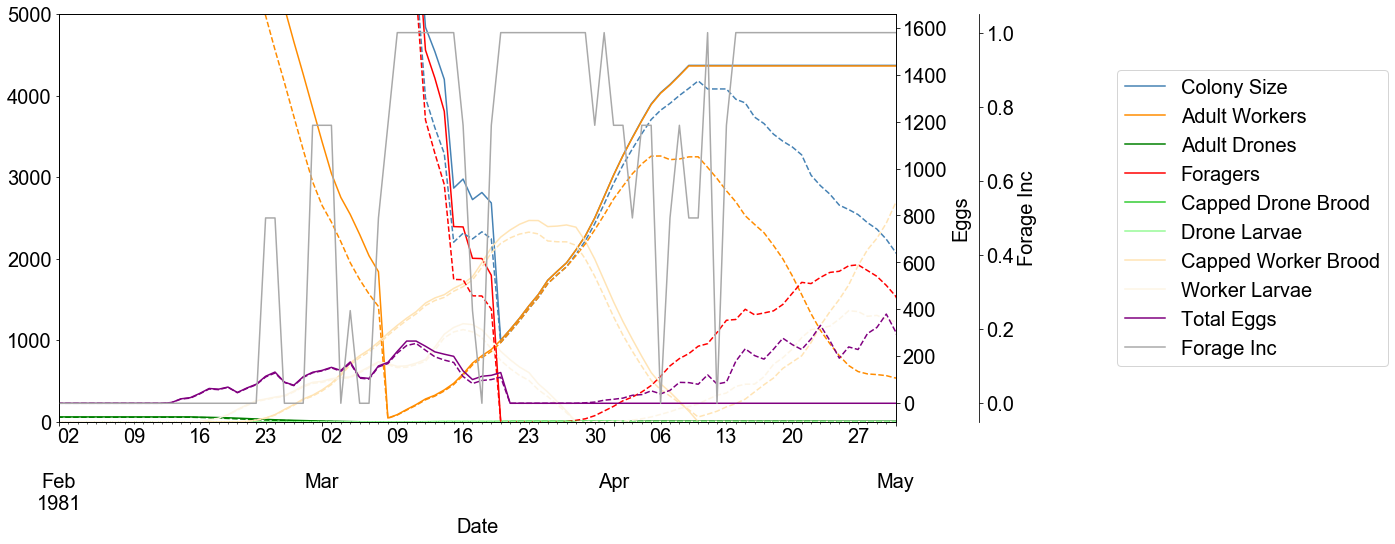

In [6]:
simulations_output_directory = 'results\okanogan'
historical_data_filename = 'observed-requeen-delay-5days-data_48.40625_-119.53125'
future_data_filename = 'rcp85-requeen-delay-5days-data_48.40625_-119.53125'

output_dir = os.path.join(simulations_output_directory, historical_data_filename)

data = get_data(output_dir)

options = Options()

#options.data = PlotsData(data['adults_aging_when_egg_laid'], data['foragers_aging_with_forage_inc_adults_aging_when_egg_laid_larvae_and_brood_become_adults'])
options.data = data['adults_aging_when_egg_laid_fixed_larvae_and_brood']
#options.data = data['foragers_aging_with_forage_inc_adults_aging_when_egg_laid']

options.columns = bees_extended

options.layout = Option(
    activated = True,
    params = BeesPlots.Type.TOP
)

options.additional_primary_data = Option(
    activated = True,
    params = {
        'data': data['adults_aging_when_egg_laid_fixed_larvae_and_brood_fixed_adults'],
        'columns': bees_extended
    }
)

options.x_limit = Option(
    activated = True,
    #params = ['1980-01-01', '1982-01-01']
    #params = ['1980-02-01', '1981-02-01']
    #params = ['1981-02-09', '1981-04-15'] # adults get stuck
    params = ['1981-02-01', '1981-05-01'] # adults get stuck
    #params = ['2054-06-01', '2056-06-01']
    #params = ['2006-02-06', '2006-04-30']
    #params = ['2050-01-01', '2055-01-01']
    #params = ['1979-01-01', '1981-07-01']
    #params = ['1990-01-01', '1993-01-01']
    #params = ['1979-01-01', '1982-01-01'] # first 2 years historical
    #params = ['1979-01-01', '1979-07-01']
)
options.y_limit = Option(
    activated = True,
    params = [0, 5000]
)
options.eggs = Option(
    activated = True,
    params = BeesPlots.Select.BOTH
)
options.temperatures = Option(
    activated = False,
    params = BeesPlots.Select.BOTH
)
options.forage_inc = Option(
    activated = True,
    params = BeesPlots.Select.BOTH
)
options.forage_day = Option(
    activated = False,
    params = BeesPlots.Select.BOTH
)
plot = BeesPlots.make_plot(options)
plot.move_legend()

AttributeError: 'NoneType' object has no attribute 'load_if_needed'

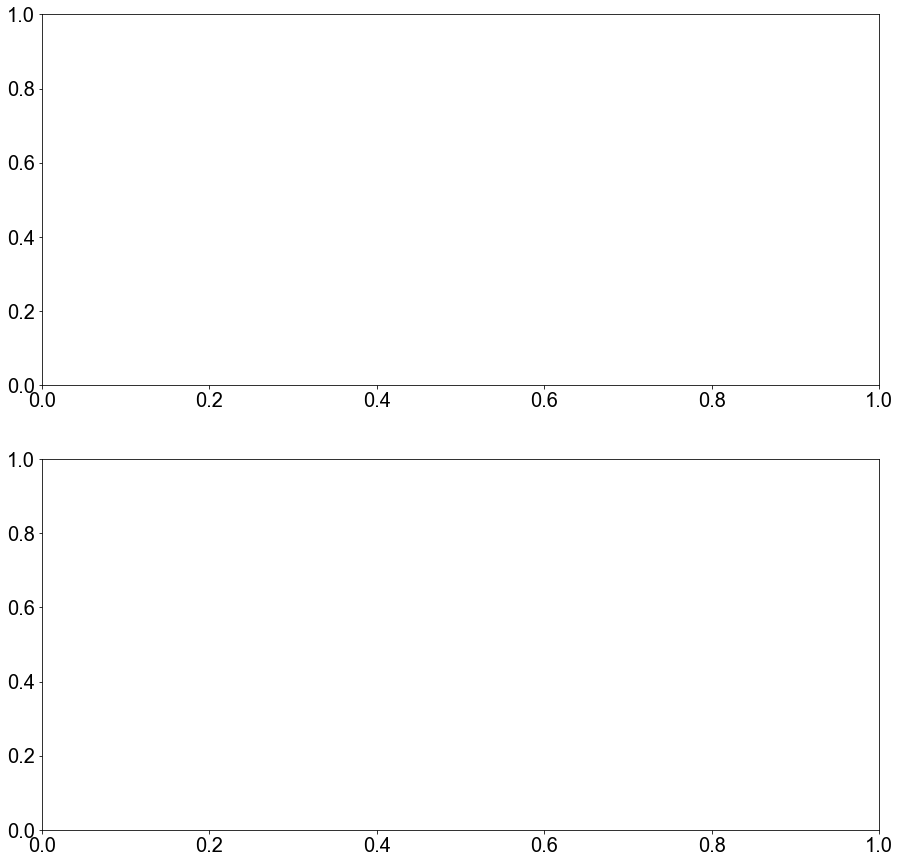

In [7]:
output_dir = os.path.join(simulations_output_directory, historical_data_filename)
data = get_data(output_dir)
options = Options()
options.data = PlotsData(data['adults_aging_when_egg_laid_fixed_larvae_and_brood_fixed_adults'], data['foragers_aging_with_forage_inc_adults_aging_when_egg_laid_fixed_larvae_and_brood_fixed_adults'])
options.columns = bees
options.x_limit = Option(
    activated = True,
    params = ['1980-02-01', '1982-07-01']
)
options.y_limit = Option(
    activated = True,
    params = [0, 50000]
)
options.eggs = Option(
    activated = True,
    params = BeesPlots.Select.BOTH
)
options.forage_inc = Option(
    activated = True,
    params = BeesPlots.Select.BOTH
)
BeesPlots.make_plot(options)

In [ ]:
options = Options()
options.data = data['foragers_and_adults_aging_with_forage_inc']
options.columns = bees
options.x_limit = Option(
    activated = True,
    params = ['1980-02-01', '1981-02-01']
)
options.y_limit = Option(
    activated = True,
    params = [0, 50000]
)
options.eggs = Option(
    activated = True,
    params = BeesPlots.Select.BOTH
)
BeesPlots.make_plot(options)

# Wenatchee

In [ ]:
simulations_output_directory = 'results\wenatchee'
historical_data_filename = 'observed-requeen-delay-5days-data_47.40625_-120.34375'
future_data_filename = 'rcp85-requeen-delay-5days-data_47.40625_-120.34375'

output_dir = os.path.join(simulations_output_directory, future_data_filename)

data = get_data(output_dir)

options.data = PlotsData(data['foragers_aging_with_forage_inc_adults_aging_when_egg_laid_fixed_larvae_and_brood'], data['foragers_and_adults_aging_with_forage_inc'])
#options.data = data['foragers_aging_with_forage_inc_adults_aging_when_egg_laid']
#options.data = data['foragers_aging_with_forage_inc_adults_aging_when_egg_laid']

options.columns = bees

options.layout = Option(
    activated = True,
    params = BeesPlots.Type.LEFT
)

options.x_limit = Option(
    activated = True,
    #params = ['1980-06-01', '1990-06-01']
    #params = ['2054-06-01', '2056-06-01']
    #params = ['2054-11-01', '2054-12-01']
    params = ['2047-03-01', '2049-04-01']
    #params = ['1979-01-01', '1981-07-01']
    #params = ['1990-01-01', '1995-01-01']
)
options.y_limit = Option(
    activated = True,
    params = [0, 20000]
)
options.eggs = Option(
    activated = True,
    params = BeesPlots.Select.BOTH
)
options.temperatures = Option(
    activated = False,
    params = BeesPlots.Select.BOTH
)
options.forage_inc = Option(
    activated = True,
    params = BeesPlots.Select.BOTH
)
options.forage_day = Option(
    activated = False,
    params = BeesPlots.Select.BOTH
)
BeesPlots.make_plot(options)

# Walla Walla

## Historical

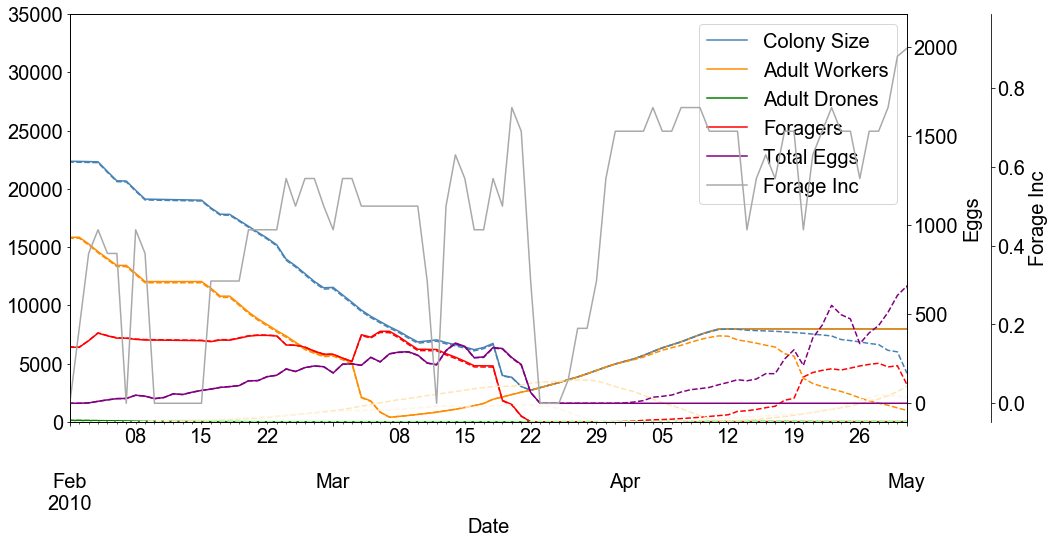

In [8]:
simulations_output_directory = 'results\walla-walla'
historical_data_filename = 'observed-requeen-delay-5days-data_46.03125_-118.34375'
future_data_filename = 'rcp85-requeen-delay-5days-data_46.03125_-118.34375'

output_dir = os.path.join(simulations_output_directory, future_data_filename)
data = get_data(output_dir)


#options.data = PlotsData(data['foragers_aging_with_forage_inc_adults_aging_when_egg_laid_fixed_larvae_and_brood'], data['foragers_and_adults_aging_with_forage_inc'])
#options.data = data['foragers_aging_with_forage_inc_adults_aging_when_egg_laid_fixed_larvae_and_brood_fixed_adults']
options.data = data['foragers_aging_with_forage_inc_adults_aging_when_egg_laid_fixed_larvae_and_brood']
#options.data = data['foragers_aging_with_forage_inc_adults_aging_when_egg_laid']

options.columns = bees

options.layout = Option(
    activated = True,
    params = BeesPlots.Type.TOP
)
options.additional_primary_data = Option(
    activated = True,
    params = {
        'data': data['foragers_aging_with_forage_inc_adults_aging_when_egg_laid_fixed_larvae_and_brood_fixed_adults'],
        'columns': bees_extended
    }
)
options.x_limit = Option(
    activated = True,
    #params = ['1980-06-01', '1990-06-01']
    #params = ['2054-06-01', '2056-06-01']
    #params = ['2054-11-01', '2054-12-01']
    #params = ['2047-03-01', '2049-04-01']
    params = ['2010-02-01', '2010-05-01']
    #params = ['1979-01-01', '1981-07-01']
    #params = ['1990-01-01', '1995-01-01']
)
options.y_limit = Option(
    activated = True,
    params = [0, 35000]
)
options.eggs = Option(
    activated = True,
    params = BeesPlots.Select.BOTH
)
options.temperatures = Option(
    activated = False,
    params = BeesPlots.Select.BOTH
)
options.forage_inc = Option(
    activated = True,
    params = BeesPlots.Select.BOTH
)
options.forage_day = Option(
    activated = False,
    params = BeesPlots.Select.BOTH
)
BeesPlots.make_plot(options)

### Future

AttributeError: 'NoneType' object has no attribute 'load_if_needed'

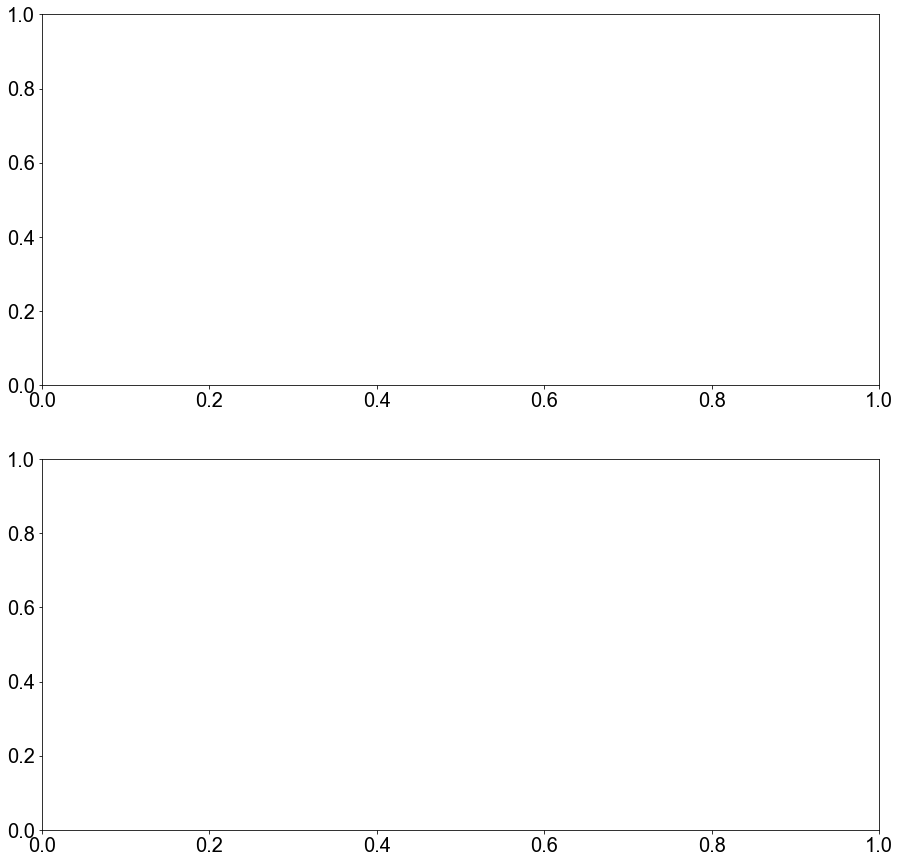

In [9]:
output_dir = os.path.join(simulations_output_directory, 'rcp85-requeen-delay-5days-data_46.03125_-118.34375')
data = get_data(output_dir)
options = Options()
options.data = PlotsData(data['adults_aging_when_egg_laid_fixed_larvae_and_brood_fixed_adults'], data['foragers_aging_with_forage_inc_adults_aging_when_egg_laid_fixed_larvae_and_brood_fixed_adults'])
options.columns = bees
options.x_limit = Option(
    activated = True,
    params = ['2060-02-01', '2070-07-01']
)
options.y_limit = Option(
    activated = True,
    params = [0, 50000]
)
options.eggs = Option(
    activated = True,
    params = BeesPlots.Select.BOTH
)
options.forage_inc = Option(
    activated = True,
    params = BeesPlots.Select.BOTH
)
BeesPlots.make_plot(options)